## 1ο Ερώτημα - Φόρτωση Δεδομένων στο colab ή local

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp '/content/drive/MyDrive/datasets/dermoscopy_classification.tar.gz' .
!tar -xvzf dermoscopy_classification.tar.gz
data_dir = '/content/dermoscopy_classification'

Local Load:

In [1]:
data_dir = 'dermoscopy_classification'

Imports:

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from torchvision import transforms, models
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torch.utils.data import random_split
from torchsummary import summary

## 2ο Ερώτημα - Φόρτωση Δεδομένων:

In [3]:
class MLProject2Dataset(Dataset):

    def __init__(self, data_dir: str, metadata_fname: str ='metadata.csv', transform: transforms = None) -> None:
        super().__init__()
        if data_dir[-1] != '/':
            data_dir += '/'

        self.data_dir = data_dir
        self.transform = transform

        imgdf = pd.DataFrame(columns=['image_id', 'path'])

        all_img_paths = glob.glob(f'{self.data_dir}**/*.jpg', recursive=True)

        for path in all_img_paths:
            image_id = os.path.basename(path).split('.')[0]
            imgdf = imgdf._append({'image_id': image_id, 'path': path}, ignore_index=True)

        metadf = pd.read_csv(self.data_dir + metadata_fname)
        metadf['dx'] = pd.Categorical(metadf['dx']).codes

        self.df = pd.merge(imgdf, metadf, on='image_id')
        # print(self.df.iloc[:, 3]) # dx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 1] # paths
        img = read_image(path)
        img = img.to(torch.float32) / 255
        # print(self.transform)
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(self.df.iloc[idx, 3], dtype=torch.int64)


2.3 , 2.4 - Testing the dataset class:

In [4]:
m, n = 64, 64

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

print(len(dataset))
print(dataset[2])

torch.manual_seed(42)   # not needed using split_lesion

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

print(train_dataset.dataset.transform)
print(valid_dataset.dataset.transform)
print(test_dataset.dataset.transform)

10015
(tensor([[[0.9281, 0.9273, 0.9301,  ..., 0.9352, 0.9286, 0.9265],
         [0.9247, 0.9213, 0.9213,  ..., 0.9381, 0.9343, 0.9285],
         [0.9028, 0.9067, 0.9107,  ..., 0.9323, 0.9253, 0.9187],
         ...,
         [0.8453, 0.8465, 0.8521,  ..., 0.6789, 0.6776, 0.6776],
         [0.8606, 0.8499, 0.8406,  ..., 0.6907, 0.6868, 0.6791],
         [0.8588, 0.8537, 0.8452,  ..., 0.7125, 0.6998, 0.6934]],

        [[0.3509, 0.3382, 0.3543,  ..., 0.3692, 0.3287, 0.3027],
         [0.3446, 0.3385, 0.3466,  ..., 0.3706, 0.3329, 0.2942],
         [0.3127, 0.3222, 0.3201,  ..., 0.3354, 0.2975, 0.2738],
         ...,
         [0.3279, 0.3263, 0.3258,  ..., 0.1089, 0.1057, 0.0998],
         [0.3466, 0.3326, 0.3184,  ..., 0.1440, 0.1300, 0.1081],
         [0.3461, 0.3318, 0.3196,  ..., 0.1798, 0.1554, 0.1374]],

        [[0.4052, 0.3829, 0.4058,  ..., 0.4576, 0.4290, 0.4072],
         [0.3979, 0.3829, 0.3929,  ..., 0.4641, 0.4359, 0.4043],
         [0.3611, 0.3664, 0.3630,  ..., 0.4214, 0.3

## 3ο Ερώτημα - Μέθοδοι Εκπαίδευσης και Δοκιμής

In [5]:
def train_net(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None, device: str = 'cpu', print_period: int = 10) -> None:
    model.train()
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, y) in enumerate(trainloader, 0):
            X = X.to(device)
            # print(y)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(X)
            current_loss = loss(pred, y)
            current_loss.backward()
            optimizer.step()
            running_loss += current_loss.item()

            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

            if batch % print_period == print_period-1:
                avg_loss = running_loss / print_period
                avg_acc = correct / total
                train_acc.append(avg_acc)
                train_loss.append(avg_loss)
                print(f'[Epoch: {epoch}, batch: {batch:5d}] Average train loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                running_loss = 0.0
                correct = 0
                total = 0

                if valloader is not None:
                    model.eval()  # evaluation mode
                    running_val_loss = 0.0
                    correct_val = 0
                    total_val = 0
                    with torch.no_grad():
                        for batch, (X, y) in enumerate(valloader, 0):
                            X, y = X.to(device), y.to(device)
                            pred = model(X)
                            current_loss = loss(pred, y)
                            running_val_loss += current_loss.item()

                            yhat = torch.argmax(pred, 1)
                            total_val += y.size(0)
                            correct_val += (yhat == y).type(torch.float).sum().item()   # counts accuracy.
                        avg_loss = running_val_loss / len(valloader)
                        avg_acc = correct_val / total_val
                        val_loss.append(avg_loss)
                        val_acc.append(avg_acc)
                        print(f'Average val loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                    model.train()  # training mode
    plot_acc_loss(train_acc, train_loss, title="Trainning Results")
    if len(val_loss) != 0 and len(val_acc) != 0:
        plot_acc_loss(val_acc, val_loss, title="Validation Results")
        plot_acc_loss(train_acc, val_acc, label1="Train Acc", label2="Valid Acc", y_label="Average Accuracy", title="Trainning VS Validation Accuracy")
        plot_acc_loss(train_loss, val_loss, label1="Train Loss", label2="Valid Loss", y_label="Average Loss", title="Trainning VS Validation Loss")


def test_net(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> None:
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (X, y) in testloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            current_loss = loss(pred, y)
            running_loss += current_loss.item()
            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())
    avg_loss = running_loss / len(testloader)
    avg_acc = correct / total
    print("===============")
    print(f"Average test loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}")
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true, y_pred))
    print("===============")


def plot_acc_loss(list1: list, list2: list, label1="Accuracy", label2="Loss", x_label=None, y_label='Avg Accuracy & Loss', title=None):
    x_values1 = list(range(len(list1)))
    x_values2 = list(range(len(list2)))

    plt.figure(figsize=(8, 6))
    plt.plot(x_values1, list1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(x_values2, list2, marker='x', linestyle='--', color='r', label=label2)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 4ο Ερώτημα - Απλό ΣΝΔ

In [6]:
class SimpleModel(nn.Module):
    """Simple convolutional neural network"""
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.conv3 = nn.Conv2d(64, 64, (3, 3))
        self.pool = nn.MaxPool2d((2, 2))
        self.fc = nn.Linear(1536, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        # used to get the input parameter in linear.
        # print(x.shape)
        x = self.fc(x)
        return x


[Epoch: 0, batch:     9] Average train loss: 1.354 | accuracy: 0.595
Average val loss: 1.501 | accuracy: 0.653
[Epoch: 0, batch:    19] Average train loss: 1.125 | accuracy: 0.695
Average val loss: 1.077 | accuracy: 0.650
[Epoch: 0, batch:    29] Average train loss: 1.060 | accuracy: 0.684
Average val loss: 1.100 | accuracy: 0.650
[Epoch: 0, batch:    39] Average train loss: 1.051 | accuracy: 0.675
Average val loss: 1.026 | accuracy: 0.650
[Epoch: 0, batch:    49] Average train loss: 1.018 | accuracy: 0.677
Average val loss: 1.001 | accuracy: 0.653
[Epoch: 0, batch:    59] Average train loss: 1.013 | accuracy: 0.669
Average val loss: 1.003 | accuracy: 0.653
[Epoch: 0, batch:    69] Average train loss: 1.064 | accuracy: 0.650
Average val loss: 0.999 | accuracy: 0.653
[Epoch: 0, batch:    79] Average train loss: 0.966 | accuracy: 0.678
Average val loss: 0.987 | accuracy: 0.651
[Epoch: 0, batch:    89] Average train loss: 1.038 | accuracy: 0.653
Average val loss: 0.971 | accuracy: 0.651
[

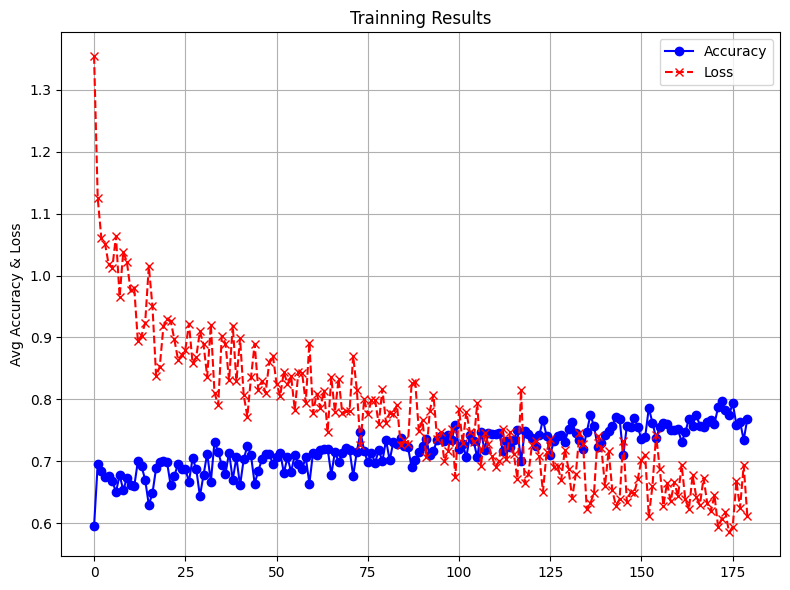

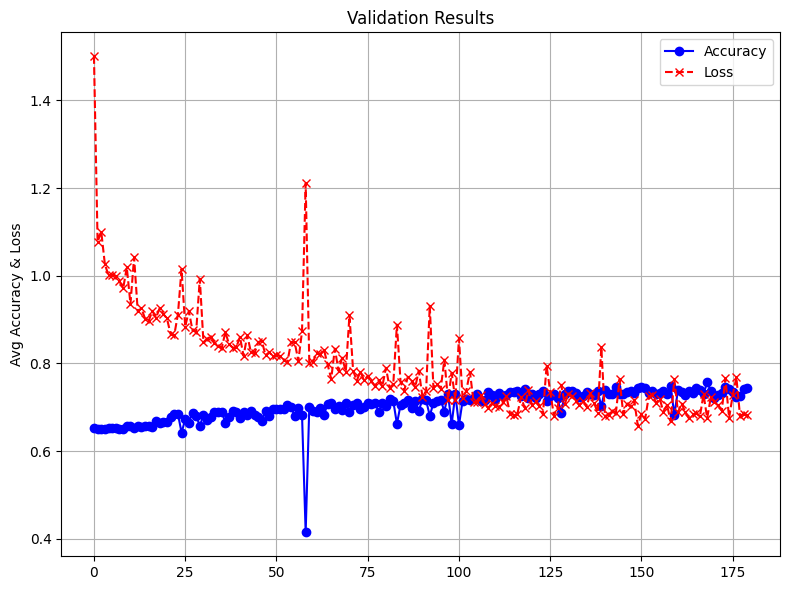

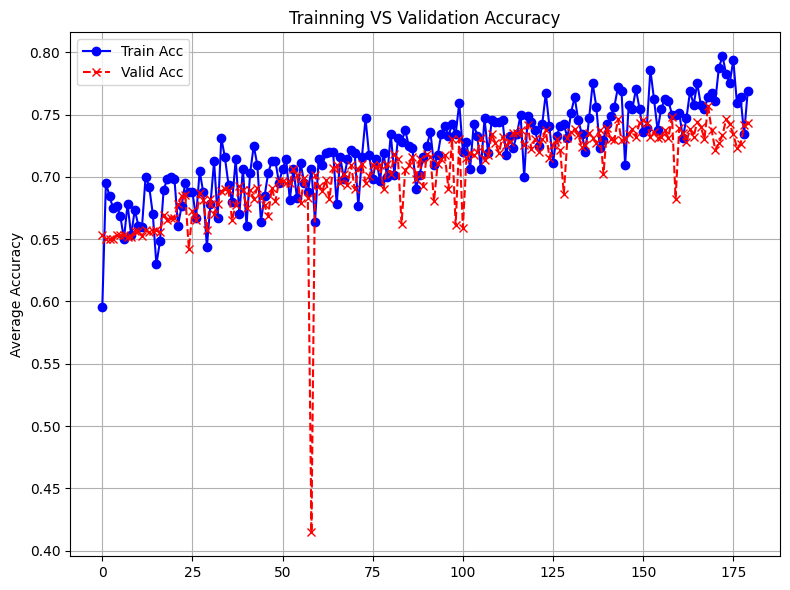

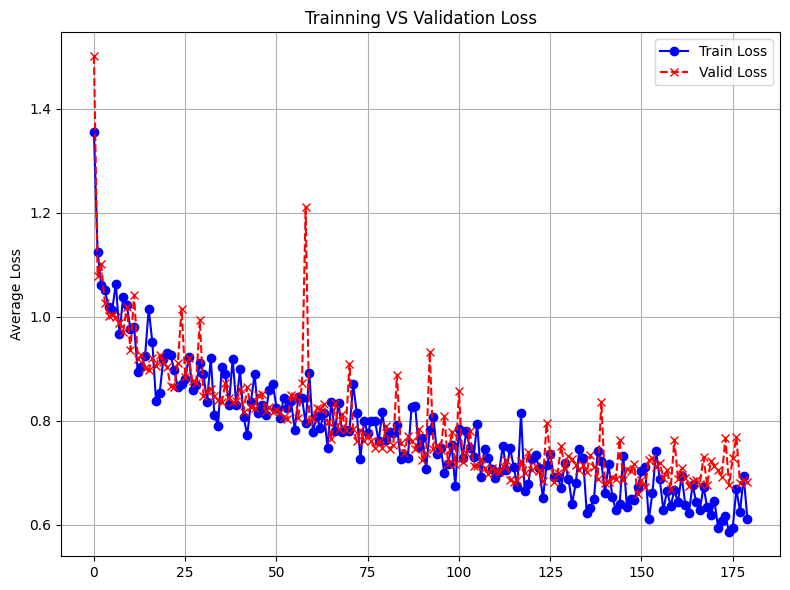

Average test loss: 0.711 | accuracy: 0.750
Confusion Matrix: 
[[  19   16    9    0   18   25    0]
 [  11   71    3    0   12   42    0]
 [   6   22   74    0   61  161    0]
 [   3   14    3    0    5   14    0]
 [   2    3    9    1  150  169    1]
 [   1   14   11    0   86 1926    1]
 [   0    6    0    0    3   18   15]]


In [7]:
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
# print(device)
m, n = 50, 62

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

torch.manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = SimpleModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

# Summary of our model
# summary(net, (3, m, n))

train_net(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)

## 5ο Ερώτημα - Σύνθετο ΣΝΔ

[Epoch: 0, batch:     9] Average train loss: 1.407 | accuracy: 0.598
Average val loss: 1.377 | accuracy: 0.650
[Epoch: 0, batch:    19] Average train loss: 0.992 | accuracy: 0.655
Average val loss: 2.272 | accuracy: 0.650
[Epoch: 0, batch:    29] Average train loss: 0.927 | accuracy: 0.661
Average val loss: 1.619 | accuracy: 0.653
[Epoch: 0, batch:    39] Average train loss: 0.797 | accuracy: 0.706
Average val loss: 1.232 | accuracy: 0.669
[Epoch: 0, batch:    49] Average train loss: 0.866 | accuracy: 0.688
Average val loss: 0.969 | accuracy: 0.688
[Epoch: 0, batch:    59] Average train loss: 0.800 | accuracy: 0.719
Average val loss: 1.010 | accuracy: 0.672
[Epoch: 0, batch:    69] Average train loss: 0.755 | accuracy: 0.722
Average val loss: 0.863 | accuracy: 0.681
[Epoch: 0, batch:    79] Average train loss: 0.788 | accuracy: 0.731
Average val loss: 0.788 | accuracy: 0.700
[Epoch: 0, batch:    89] Average train loss: 0.787 | accuracy: 0.719
Average val loss: 0.739 | accuracy: 0.732
[

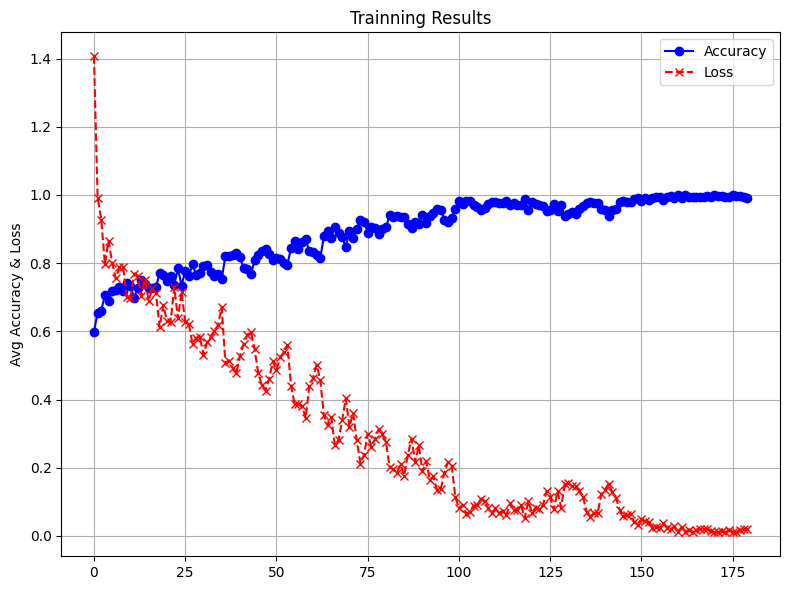

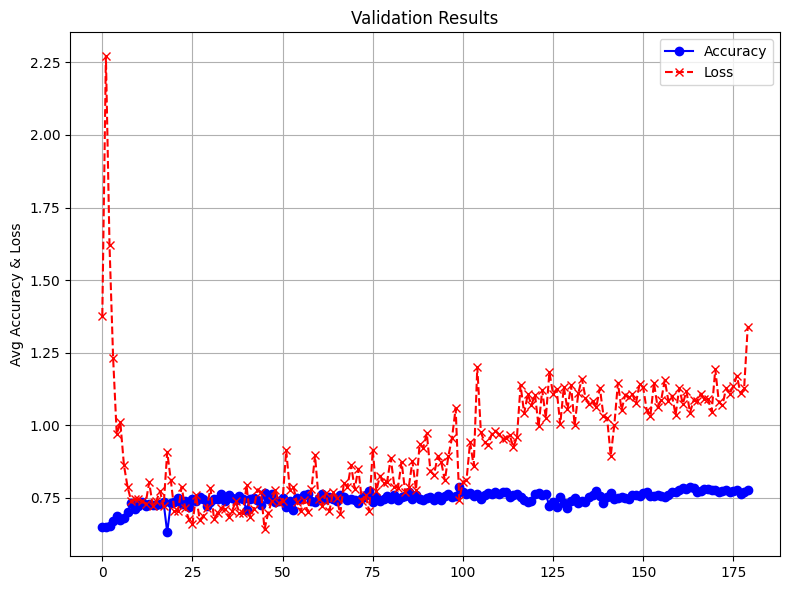

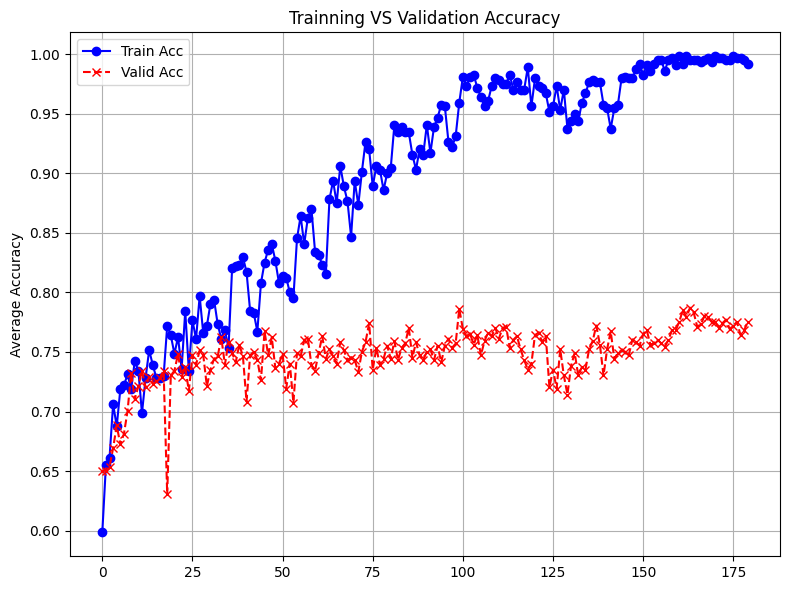

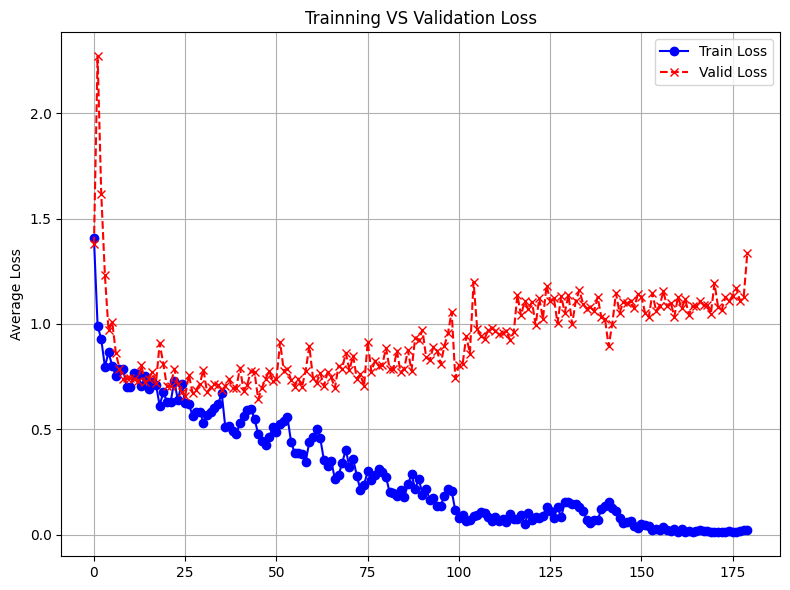

Average test loss: 1.190 | accuracy: 0.781
Confusion Matrix: 
[[  26   11   27    1    9   13    0]
 [   9   81   14    3    4   26    2]
 [   8   15  180    2   20   97    2]
 [   3    7    3   16    0   10    0]
 [   7    3   38    2  140  144    1]
 [   5   36   46    0   71 1876    5]
 [   0    1    2    0    1    9   29]]


In [8]:
class ComplexModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, (3, 3))
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, (3, 3))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, (3, 3))
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, (3, 3))
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512, (3, 3))
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d((2, 2))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc(x)
        return x


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

m, n = 100, 125

transform = transforms.Compose([
    transforms.Resize((m, n), antialias=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MLProject2Dataset(data_dir, transform=transform)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

torch.manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = ComplexModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

train_net(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)


## 6ο Ερώτημα - Μεταφορά Μάθησης

[Epoch: 0, batch:     9] Average train loss: 1.398 | accuracy: 0.603
Average val loss: 1.112 | accuracy: 0.649
[Epoch: 0, batch:    19] Average train loss: 0.987 | accuracy: 0.673
Average val loss: 1.000 | accuracy: 0.657
[Epoch: 0, batch:    29] Average train loss: 0.902 | accuracy: 0.694
Average val loss: 0.948 | accuracy: 0.670
[Epoch: 0, batch:    39] Average train loss: 0.883 | accuracy: 0.698
Average val loss: 0.898 | accuracy: 0.681
[Epoch: 0, batch:    49] Average train loss: 0.897 | accuracy: 0.684
Average val loss: 0.856 | accuracy: 0.688
[Epoch: 0, batch:    59] Average train loss: 0.860 | accuracy: 0.711
Average val loss: 0.808 | accuracy: 0.692
[Epoch: 0, batch:    69] Average train loss: 0.873 | accuracy: 0.692
Average val loss: 0.795 | accuracy: 0.703
[Epoch: 0, batch:    79] Average train loss: 0.753 | accuracy: 0.725
Average val loss: 0.757 | accuracy: 0.714
[Epoch: 0, batch:    89] Average train loss: 0.772 | accuracy: 0.725
Average val loss: 0.736 | accuracy: 0.726
[

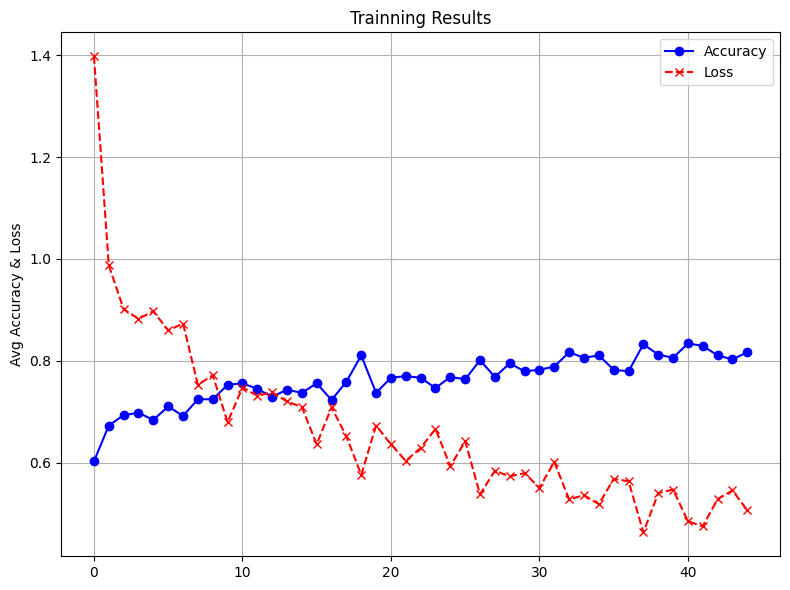

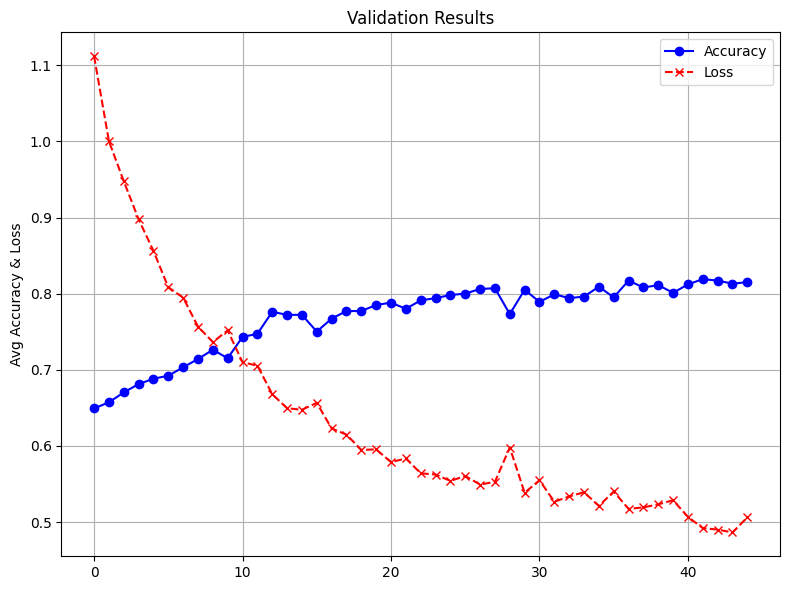

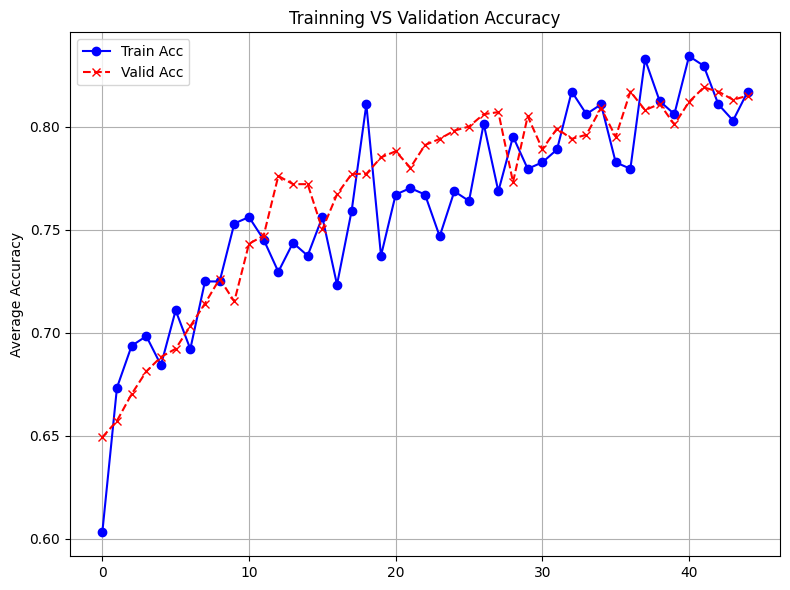

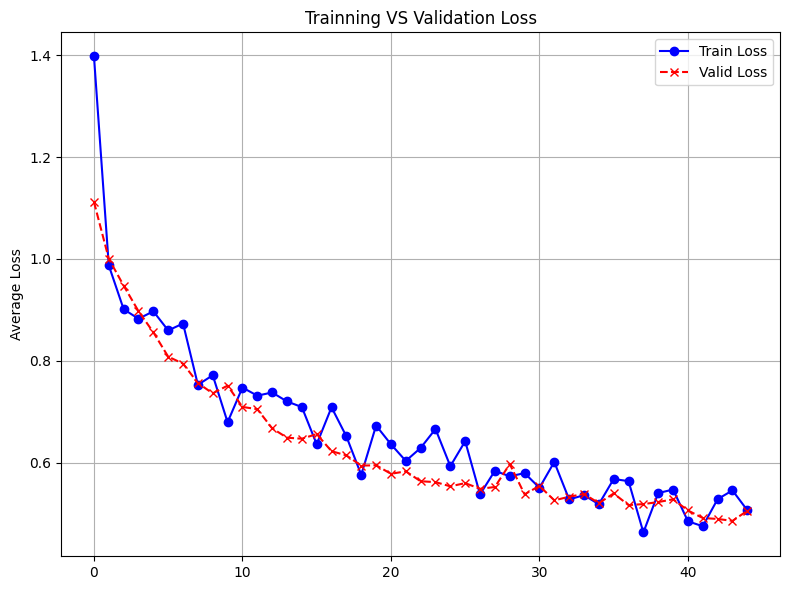

Average test loss: 0.480 | accuracy: 0.828
Confusion Matrix: 
[[  48    6   17    0    6   10    0]
 [  12  104    7    0    5   11    0]
 [   6    8  222    2   11   75    0]
 [   3    2    9    2    2   18    3]
 [   9    3   45    0  118  160    0]
 [   2   11   42    1   22 1960    1]
 [   0    3    1    0    0    5   33]]


In [13]:
import copy

device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

# print(device)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, antialias=True),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


dataset = MLProject2Dataset(data_dir, transform=data_transforms['train'])

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

torch.manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

train_dataset.dataset = copy.deepcopy(dataset)
train_dataset.dataset.transform =  data_transforms['train']

valid_dataset.dataset = copy.deepcopy(dataset)
valid_dataset.dataset.transform =  data_transforms['val']

test_dataset.dataset = copy.deepcopy(dataset)
test_dataset.dataset.transform =  data_transforms['val']

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = models.resnet34(weights='DEFAULT').to(device)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 7).to(device)

loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_net(net, trainloader, valloader, epochs=5, optimizer=optimizer, loss=loss, device=device)
test_net(net, testloader, loss, device)

## 7ο Ερώτημα - Αξιοποίηση Δημογραφικών Δεδομένων

In [10]:
class BonusMLProject2Dataset(MLProject2Dataset):
    def __init__(self, data_dir: str, metadata_fname: str ='metadata.csv', transform: transforms = None) -> None:
        super().__init__(data_dir, metadata_fname, transform)
        self.df['age'] = self.df['age'] / 100
        self.df['age'].fillna(self.df['age'].mean(), inplace=True)
        columns_to_encode = ['sex', 'localization']
        one_hot = pd.get_dummies(self.df[columns_to_encode])
        self.df = pd.concat([self.df, one_hot], axis=1)
        self.df.drop(columns_to_encode, axis=1, inplace=True)

    def __getitem__(self, idx):
        path = self.df.iloc[idx, 1] # paths
        img = read_image(path)
        img = img.to(torch.float32) / 255

        if self.transform:
            img = self.transform(img)
        p = pd.Series(self.df.iloc[idx, 5:]).values.astype(np.float64)
        p = torch.from_numpy(p).float()
        return img, p, torch.tensor(self.df.iloc[idx, 3], dtype=torch.int64)


In [11]:
def train_net_bonus(model: nn.Module, trainloader: DataLoader, valloader: DataLoader = None, epochs: int = 10, optimizer: optim = None, loss: nn.modules.loss = None, device: str = 'cpu', print_period: int = 10) -> None:
    model.train()
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for batch, (X, p, y) in enumerate(trainloader, 0):
            X = X.to(device)
            p = p.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            pred = model(X, p)
            current_loss = loss(pred, y)
            current_loss.backward()
            optimizer.step()
            running_loss += current_loss.item()

            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

            if batch % print_period == print_period-1:
                avg_loss = running_loss / print_period
                avg_acc = correct / total
                train_acc.append(avg_acc)
                train_loss.append(avg_loss)
                print(f'[Epoch: {epoch}, batch: {batch:5d}] Average train loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                running_loss = 0.0
                correct = 0
                total = 0

                if valloader is not None:
                    model.eval()  # evaluation mode
                    running_val_loss = 0.0
                    correct_val = 0
                    total_val = 0
                    with torch.no_grad():
                        for batch, (X, p, y) in enumerate(valloader, 0):
                            X, y = X.to(device), y.to(device)
                            p = p.to(device)
                            pred = model(X, p)
                            current_loss = loss(pred, y)
                            running_val_loss += current_loss.item()

                            yhat = torch.argmax(pred, 1)
                            total_val += y.size(0)
                            correct_val += (yhat == y).type(torch.float).sum().item()   # counts accuracy.

                        avg_loss = running_val_loss / len(valloader)
                        avg_acc = correct_val / total_val
                        val_loss.append(avg_loss)
                        val_acc.append(avg_acc)
                        print(f'Average val loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}')
                    model.train()  # training mode
    plot_acc_loss(train_acc, train_loss, title="Trainning Results")
    if len(val_loss) != 0 and len(val_acc) != 0:
        plot_acc_loss(val_acc, val_loss, title="Validation Results")
        plot_acc_loss(train_acc, val_acc, label1="Train Acc", label2="Valid Acc", y_label="Average Accuracy", title="Trainning VS Validation Accuracy")
        plot_acc_loss(train_loss, val_loss, label1="Train Loss", label2="Valid Loss", y_label="Average Loss", title="Trainning VS Validation Loss")


def test_net_bonus(model: nn.Module, testloader: DataLoader, loss: nn.modules.loss = None, device: str = 'cpu') -> None:
    model.eval()
    total = 0
    correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for (X, p, y) in testloader:
            X, y = X.to(device), y.to(device)
            p = p.to(device)
            pred = model(X, p)
            current_loss = loss(pred, y)
            running_loss += current_loss.item()
            yhat = torch.argmax(pred, 1)
            total += y.size(0)
            correct += (yhat == y).type(torch.float).sum().item()
            y_true.extend(y.cpu().numpy())
            y_pred.extend(yhat.cpu().numpy())
    avg_loss = running_loss / len(testloader)
    avg_acc = correct / total
    print("===============")
    print(f"Average test loss: {avg_loss:.3f} | accuracy: {avg_acc:.3f}")
    print("Confusion Matrix: ")
    print(confusion_matrix(y_true, y_pred))
    print("===============")

[Epoch: 0, batch:     9] Average train loss: 1.554 | accuracy: 0.605
Average val loss: 1.291 | accuracy: 0.650
[Epoch: 0, batch:    19] Average train loss: 1.141 | accuracy: 0.692
Average val loss: 1.198 | accuracy: 0.650
[Epoch: 0, batch:    29] Average train loss: 1.145 | accuracy: 0.662
Average val loss: 1.165 | accuracy: 0.650
[Epoch: 0, batch:    39] Average train loss: 1.068 | accuracy: 0.681
Average val loss: 1.132 | accuracy: 0.650
[Epoch: 0, batch:    49] Average train loss: 1.071 | accuracy: 0.670
Average val loss: 1.105 | accuracy: 0.650
[Epoch: 0, batch:    59] Average train loss: 1.041 | accuracy: 0.664
Average val loss: 1.087 | accuracy: 0.650
[Epoch: 0, batch:    69] Average train loss: 1.084 | accuracy: 0.641
Average val loss: 1.057 | accuracy: 0.650
[Epoch: 0, batch:    79] Average train loss: 1.011 | accuracy: 0.680
Average val loss: 1.030 | accuracy: 0.651
[Epoch: 0, batch:    89] Average train loss: 1.001 | accuracy: 0.664
Average val loss: 1.011 | accuracy: 0.656
[

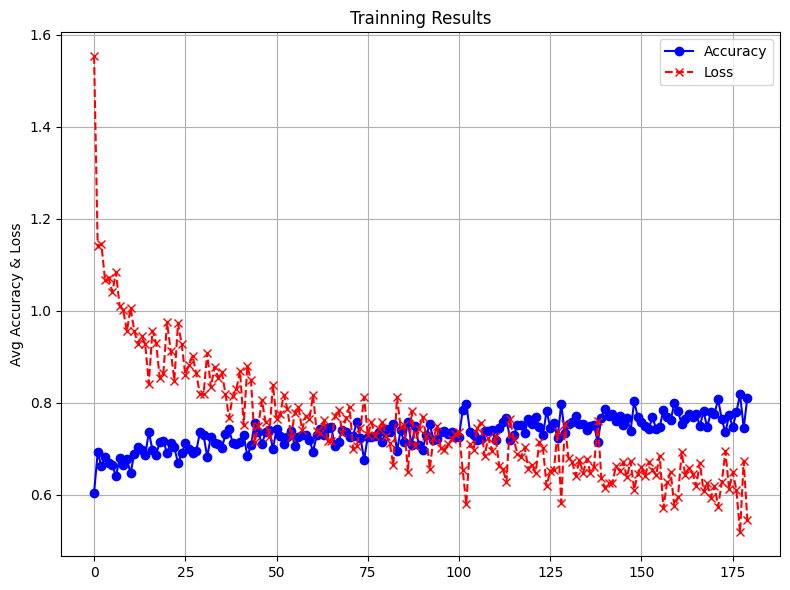

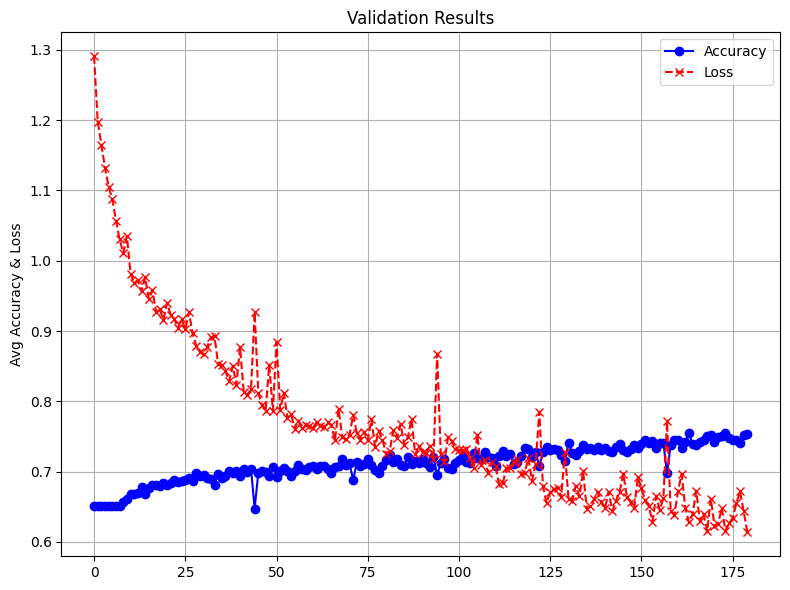

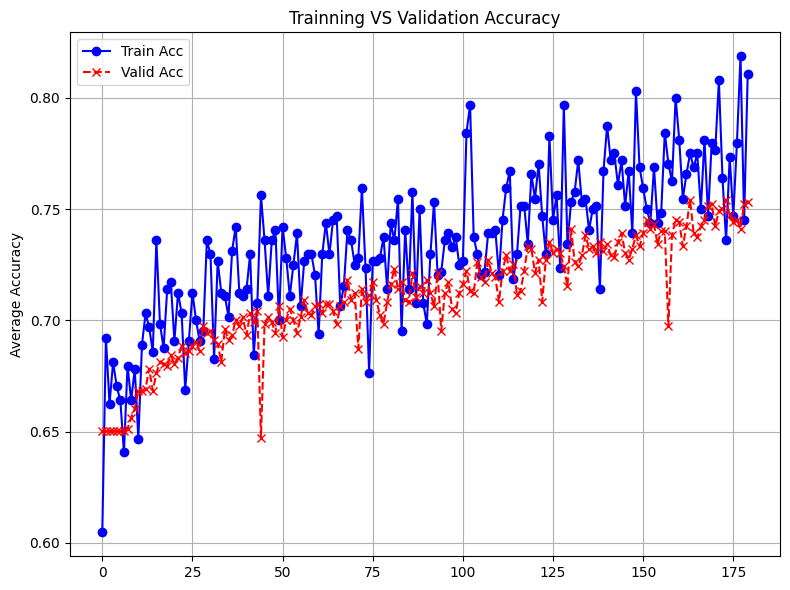

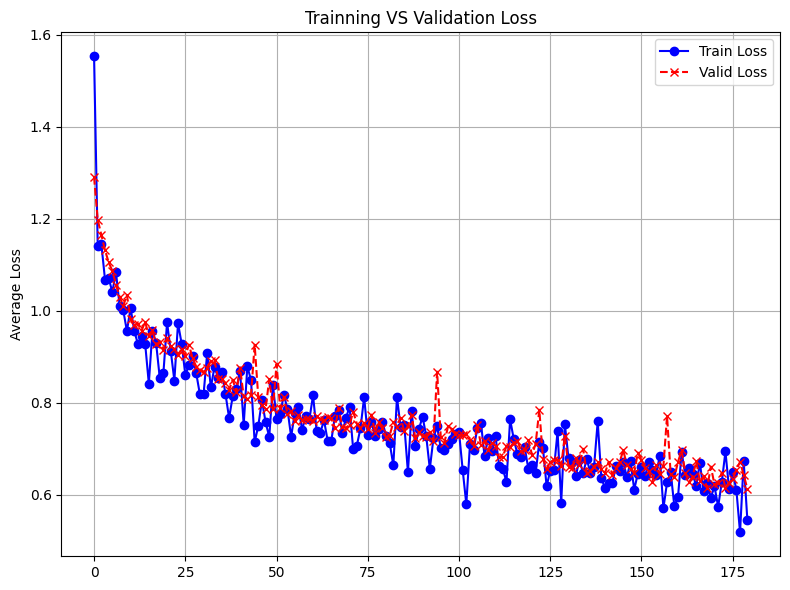

Average test loss: 0.660 | accuracy: 0.761
Confusion Matrix: 
[[  24   34   25    0    1    3    0]
 [  11   99   14    1    2    9    3]
 [   9   49  186    0    9   71    0]
 [   6   14    3    4    0   12    0]
 [  12   19   72    0   79  150    3]
 [  12   37   79    1   25 1877    8]
 [   0   11    1    2    1    9   18]]


In [12]:
class BonusModel(nn.Module):
    def __init__(self):
        device = ("cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu")
        super().__init__()
        self.simple_cnn = SimpleModel()
        self.fc = nn.Linear(19, 128)
        self.fc2 = nn.Linear(135, 7).to(device)

    def forward(self, X, p):
        c = self.simple_cnn(X)
        f = F.relu(self.fc(p))
        x = torch.cat((c.view(c.size(0), -1), f.view(f.size(0), -1)), dim=1)
        x = self.fc2(x)
        return x

device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

m, n = 50, 62

transform = transforms.Compose([
   transforms.Resize((m, n), antialias=True),
   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = BonusMLProject2Dataset(data_dir, transform=transform)

train_size = int(0.6 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

torch.manual_seed(42)
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

BATCH_SIZE = 64
trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

net = BonusModel().to(device)
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

# Summary of our model
# summary(net, (3, m, n))

train_net_bonus(net, trainloader, valloader, epochs=20, optimizer=optimizer, loss=loss, device=device)
test_net_bonus(net, testloader, loss, device)